# WARNING: this is completely unpolished code

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import logging, os, json, glob, csv
import gensim
import matplotlib.pyplot as plt
from gensim import corpora, models, similarities
from collections import defaultdict
from pprint import pprint
from scipy.io import loadmat 
import sklearn

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.level = logging.WARN
basedir = """C:\chords\McGill-Billboard"""


In [857]:
with open(r"C:\chords\McGill-Billboard\0004\echonest.json", 'r') as f:
    j = json.load(f)
    
# Load metadata and filter to songs in model
%matplotlib inline
sns.set(style="dark", context="poster")
#sns.set(style="whitegrid")

index = pd.read_csv(r"C:\chords\McGill-Billboard\billboard-2.0-index.csv",
                   parse_dates=['chart_date'])
index.set_index('id', inplace=True)

with open(r"C:\chords\McGill-Billboard\kept_songs.txt", 'r') as f:
    kept_songs = [int(num) for num in f.readlines()]
songs = index.filter(items=kept_songs,axis=0)

song_lookup = {i+1: kept_songs[i] for i in xrange(len(kept_songs))}
song_lookup


{1: 10,
 2: 100,
 3: 1003,
 4: 1006,
 5: 1007,
 6: 1009,
 7: 101,
 8: 1011,
 9: 1012,
 10: 1013,
 11: 1014,
 12: 1016,
 13: 1018,
 14: 1019,
 15: 102,
 16: 1020,
 17: 1021,
 18: 1022,
 19: 1024,
 20: 1025,
 21: 1027,
 22: 1031,
 23: 1032,
 24: 1033,
 25: 1034,
 26: 1037,
 27: 1039,
 28: 104,
 29: 1040,
 30: 1041,
 31: 1042,
 32: 1044,
 33: 1045,
 34: 1046,
 35: 1048,
 36: 105,
 37: 1051,
 38: 1052,
 39: 1053,
 40: 1054,
 41: 1055,
 42: 1056,
 43: 1058,
 44: 1059,
 45: 106,
 46: 1061,
 47: 1062,
 48: 1063,
 49: 1064,
 50: 1066,
 51: 1067,
 52: 1068,
 53: 1069,
 54: 107,
 55: 1070,
 56: 1071,
 57: 1072,
 58: 1073,
 59: 1076,
 60: 1078,
 61: 1082,
 62: 1084,
 63: 1085,
 64: 1086,
 65: 1087,
 66: 1089,
 67: 109,
 68: 1091,
 69: 1094,
 70: 1096,
 71: 1097,
 72: 1098,
 73: 1099,
 74: 1100,
 75: 1101,
 76: 1102,
 77: 1103,
 78: 1104,
 79: 1106,
 80: 1107,
 81: 1109,
 82: 111,
 83: 1110,
 84: 1111,
 85: 1112,
 86: 1113,
 87: 1114,
 88: 1116,
 89: 1117,
 90: 1118,
 91: 1119,
 92: 112,
 93: 1120

In [3]:
j['track']['tempo']
j['sections']
j['meta']
j

{u'bars': [{u'confidence': 0.03, u'duration': 3.00288, u'start': 1.4577},
  {u'confidence': 0.723, u'duration': 3.00965, u'start': 4.46058},
  {u'confidence': 0.036, u'duration': 3.01284, u'start': 7.47023},
  {u'confidence': 0.009, u'duration': 3.04281, u'start': 10.48307},
  {u'confidence': 0.03, u'duration': 3.03409, u'start': 13.52588},
  {u'confidence': 0.275, u'duration': 2.98974, u'start': 16.55997},
  {u'confidence': 0.073, u'duration': 2.98604, u'start': 19.54971},
  {u'confidence': 0.053, u'duration': 2.95534, u'start': 22.53575},
  {u'confidence': 0.11, u'duration': 2.95411, u'start': 25.49108},
  {u'confidence': 0.208, u'duration': 2.91401, u'start': 28.4452},
  {u'confidence': 0.001, u'duration': 2.92281, u'start': 31.35921},
  {u'confidence': 0.03, u'duration': 2.91536, u'start': 34.28201},
  {u'confidence': 0.05, u'duration': 2.90433, u'start': 37.19737},
  {u'confidence': 0.006, u'duration': 2.89626, u'start': 40.1017},
  {u'confidence': 0.0, u'duration': 2.89817, u'sta

In [234]:
with open(r"C:\chords\McGill-Billboard\billboard-2.0-index.csv", 'r') as f:
    r = csv.reader(f)
    for row in r:
        print row
    
    

    

['id', 'chart_date', 'target_rank', 'actual_rank', 'title', 'artist', 'peak_rank', 'weeks_on_chart']
['1', '1987-07-11', '82', '', '', '', '', '']
['2', '1973-08-04', '14', '', '', '', '', '']
['3', '1961-07-03', '56', '57', "I Don't Mind", 'James Brown', '47', '8']
['4', '1971-08-07', '32', '31', "You've Got A Friend", 'Roberta Flack,Donny Hathaway', '29', '12']
['5', '1976-07-10', '51', '', '', '', '', '']
['6', '1980-08-02', '15', '16', 'The Rose', 'Bette Midler', '3', '25']
['7', '1972-10-07', '37', '', '', '', '', '']
['8', '1963-04-13', '67', '', '', '', '', '']
['9', '1991-05-25', '48', '', '', '', '', '']
['10', '1984-03-24', '49', '51', 'An Innocent Man', 'Billy Joel', '10', '18']
['11', '1960-01-25', '97', '', '', '', '', '']
['12', '1980-11-15', '65', '63', "Lookin' For Love", 'Johnny Lee', '5', '21']
['13', '1973-08-18', '14', '', '', '', '', '']
['14', '1969-01-04', '56', '', '', '', '', '']
['15', '1976-08-07', '21', '21', 'Last Child', 'Aerosmith', '21', '15']
['16', '19

In [344]:
wtm = loadmat(r"C:\RTM\model\nwt.mat")

wtm = [row / float(sum(row)) for row in wtm['Nwt'].T]
wtm[0]

(615L, 16L)


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00966184,  0.        ,  0.01630435,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00241546,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00422705,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.04408213,  0.        ,
        0.        ,  0.17753623,  0.00483092,  0.        ,  0.  

In [339]:
with open(r"C:\RTM\model\new.txt", 'r') as f:
    sections = eval(f.readlines()[0])

In [341]:
for i, section in enumerate(sections):
    if section:
        
        

[(16, 1)]
[(167, 2), (321, 1)]
[(25, 1)]
[(101, 2)]
[]
[]
[(50, 1), (53, 1)]
[]
[]
[]
[]
[]
[(63, 1)]
[]
[(72, 1), (73, 1), (76, 1)]
[]
[]
[]
[]
[(37, 2), (66, 1)]
[(94, 2)]
[(64, 1)]
[]
[(96, 1)]
[(108, 2)]
[]
[(114, 1)]
[(80, 1), (92, 1)]
[(108, 2)]
[]
[(9, 2), (23, 2), (35, 4), (123, 2)]
[(127, 1)]
[(0, 1), (24, 2), (133, 1)]
[(144, 1)]
[]
[(66, 1), (155, 1)]
[(69, 1), (101, 1), (165, 1)]
[(81, 2), (91, 2)]
[(19, 1), (31, 1)]
[(19, 1), (21, 1), (167, 1), (200, 1)]
[(21, 1), (24, 1), (200, 1), (402, 1)]
[(24, 1)]
[(7, 1), (49, 1), (84, 1), (108, 1), (344, 1)]
[(165, 1)]
[(149, 1), (361, 1)]
[(41, 2)]
[(66, 1)]
[]
[(114, 1)]
[(140, 1)]
[(66, 1), (108, 1)]
[]
[]
[(225, 2)]
[(225, 3)]
[]
[(178, 1)]
[]
[(24, 2), (166, 2), (209, 1)]
[(25, 1)]
[(24, 1), (218, 1)]
[(2, 2), (7, 1)]
[(2, 2), (53, 2), (66, 2), (82, 2)]
[(2, 2), (7, 1)]
[(2, 4), (7, 2), (24, 3), (29, 4), (35, 4), (49, 1), (50, 1), (53, 4), (66, 1), (110, 3)]
[(113, 2), (549, 2)]
[(84, 1), (221, 1), (296, 2)]
[(216, 1)]
[(41, 1)

In [860]:
lda = loadmat(r"c:\RTM\model\props.mat")['props']
topics = pd.DataFrame(lda, index=[song_lookup[i] for i in xrange(1,len(lda)+1)], columns=xrange(1,17))
nulls = [i + 1 for i in xrange(len(lda)) if sum(pd.isnull(topics.irow(i)))]
# docIDs for docs w/o tokens
remaining_songs =  len(lda) - len(nulls)
topics = topics.dropna()
topics
        

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.305556,0.277778,0.000000,0.000000,0.333333,0.000000,0.000000
1003,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.476190,0.000000,0.000000,0.000000,0.000000,0.000000
1006,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1007,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.100000,0.800000,0.000000,0.000000,0.000000,0.050000
1009,0.000000,0.000000,0.192308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.807692,0.000000,0.000000,0.000000,0.000000,0.000000
101,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.550000,0.050000,0.000000,0.000000,0.000000,0.000000
1011,0.000000,0.000000,0.483871,0.354839,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.064516,0.000000,0.000000,0.000000,0.000000,0.064516
1012,0.000000,0.000000,0.210526,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.526316,0.210526,0.000000,0.000000,0.000000,0.000000
1013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1014,0.200000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


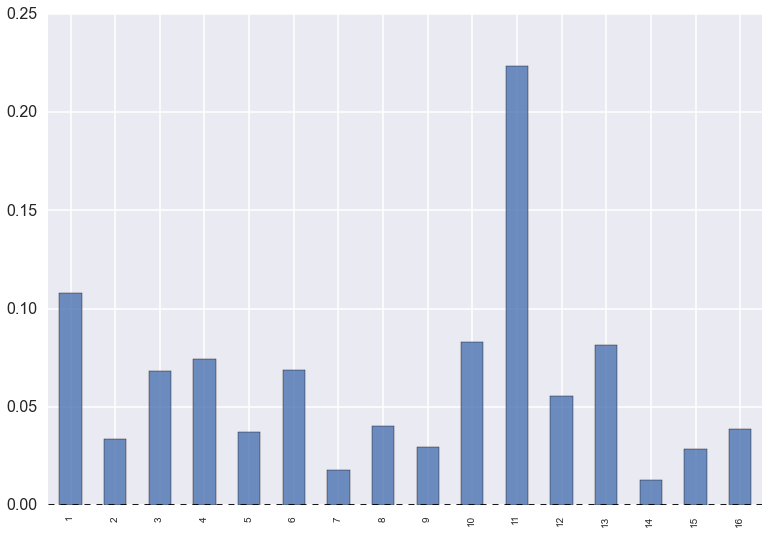

In [236]:
# Plot weighted corpus-wide topic proportions
topics.mean().plot(kind='bar', alpha=0.8)

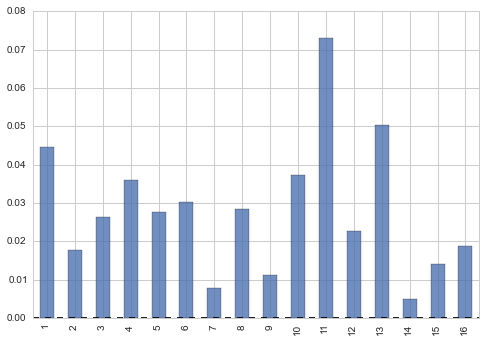

In [8]:
topics.var().plot(kind='bar', alpha=0.8)

In [313]:
topics

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.305556,0.277778,0.000000,0.000000,0.333333,0.000000,0.000000
1003,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.476190,0.000000,0.000000,0.000000,0.000000,0.000000
1006,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1007,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.100000,0.800000,0.000000,0.000000,0.000000,0.050000
1009,0.000000,0.000000,0.192308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.807692,0.000000,0.000000,0.000000,0.000000,0.000000
101,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.550000,0.050000,0.000000,0.000000,0.000000,0.000000
1011,0.000000,0.000000,0.483871,0.354839,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.064516,0.000000,0.000000,0.000000,0.000000,0.064516
1012,0.000000,0.000000,0.210526,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.526316,0.210526,0.000000,0.000000,0.000000,0.000000
1013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1014,0.200000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [312]:
# import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram

clf = AgglomerativeClustering(n_clusters=8)
clf.fit_predict(topics)

# def plot_dendrogram(model, **kwargs):

#     # Children of hierarchical clustering
#     children = model.children_

#     # Distances between each pair of children
#     # Since we don't have this information, we can use a uniform one for plotting
#     distance = np.arange(children.shape[0])

#     # The number of observations contained in each cluster level
#     no_of_observations = np.arange(2, children.shape[0]+2)

#     # Create linkage matrix and then plot the dendrogram
#     linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)

#plt.title('Hierarchical Clustering Dendrogram')
#plot_dendrogram(clf,labels = clf.labels_)
#plt.show()
    

array([0, 3, 0, 0, 1, 1, 4, 1, 1, 2, 0, 3, 1, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3, 3, 6, 0, 0, 1, 0, 6, 0, 4, 0, 1, 3,
       4, 6, 0, 0, 7, 0, 0, 0, 0, 6, 1, 3, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 3,
       1, 0, 6, 7, 4, 0, 3, 3, 0, 6, 2, 2, 1, 3, 1, 5, 0, 0, 1, 4, 0, 3, 1,
       2, 0, 1, 1, 7, 2, 4, 0, 1, 5, 7, 1, 4, 0, 0, 0, 1, 6, 0, 1, 2, 7, 1,
       4, 0, 0, 0, 3, 0, 0, 3, 7, 0, 0, 0, 2, 0, 0, 3, 0, 1, 0, 3, 0, 0, 1,
       3, 1, 0, 4, 1, 3, 2, 0, 1, 1, 4, 1, 5, 3, 0, 1, 4, 1, 0, 3, 1, 1, 0,
       0, 3, 0, 3, 3, 0, 0, 3, 5, 4, 0, 3, 0, 0, 0, 0, 1, 0, 4, 0, 2, 1, 1,
       3, 1, 0, 0, 7, 0, 6, 2, 0, 4, 0, 0, 0, 1, 0, 1, 0, 1, 6, 0, 0, 6, 0,
       7, 0, 1, 3, 0, 1, 3, 1, 0, 7, 6, 5, 7, 4, 0, 0, 6, 4, 0, 6, 4, 3, 0,
       0, 0, 0, 3, 0, 0, 0, 7, 6, 5, 7, 5, 1, 4, 6, 5, 0, 0, 7, 1, 0, 3, 5,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 7, 2, 5, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 6, 2, 0, 0, 1, 0, 0, 1, 3, 3, 0, 4, 1, 4, 3, 1, 0, 1, 0, 1, 1, 1,
       1, 1,

{'color_list': ['g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'c',
  'c',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',

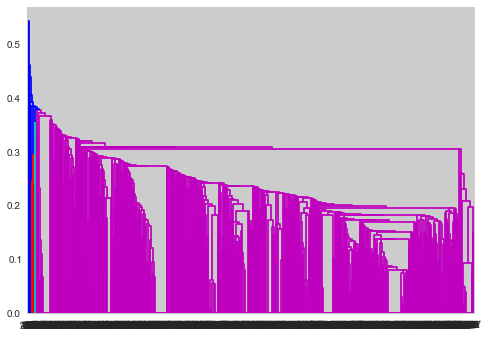

In [47]:
import scipy
x = scipy.cluster.hierarchy.linkage(np.array(topics))
scipy.cluster.hierarchy.dendrogram(x)

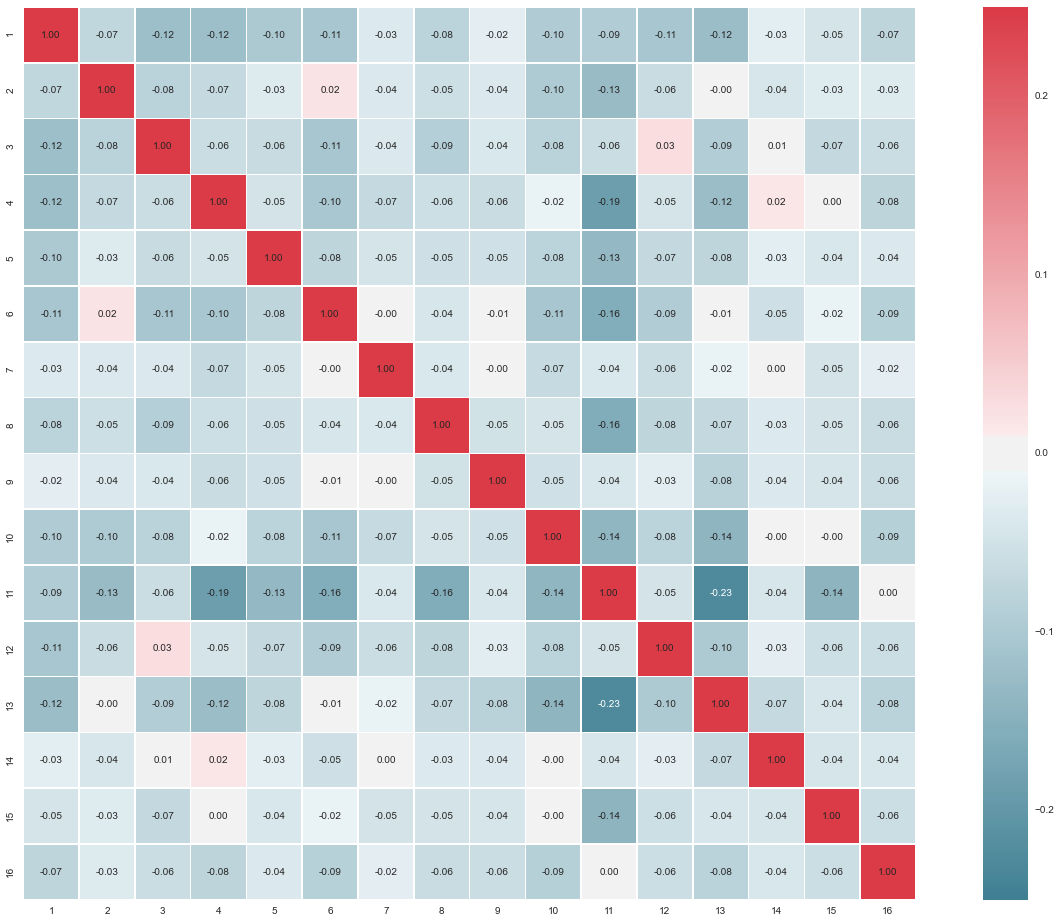

In [22]:
# 13, 11, weak diatonics
# pearson's r for topix
#b
# Set up the matplotlib figure
sns.set(style="whitegrid")
corr = topics.corr()
f, ax = plt.subplots(figsize=(24, 16))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr,cmap=cmap, vmax=.25,
            square=True,annot=True, fmt = ".2f",
            linewidths=.1, ax=ax)




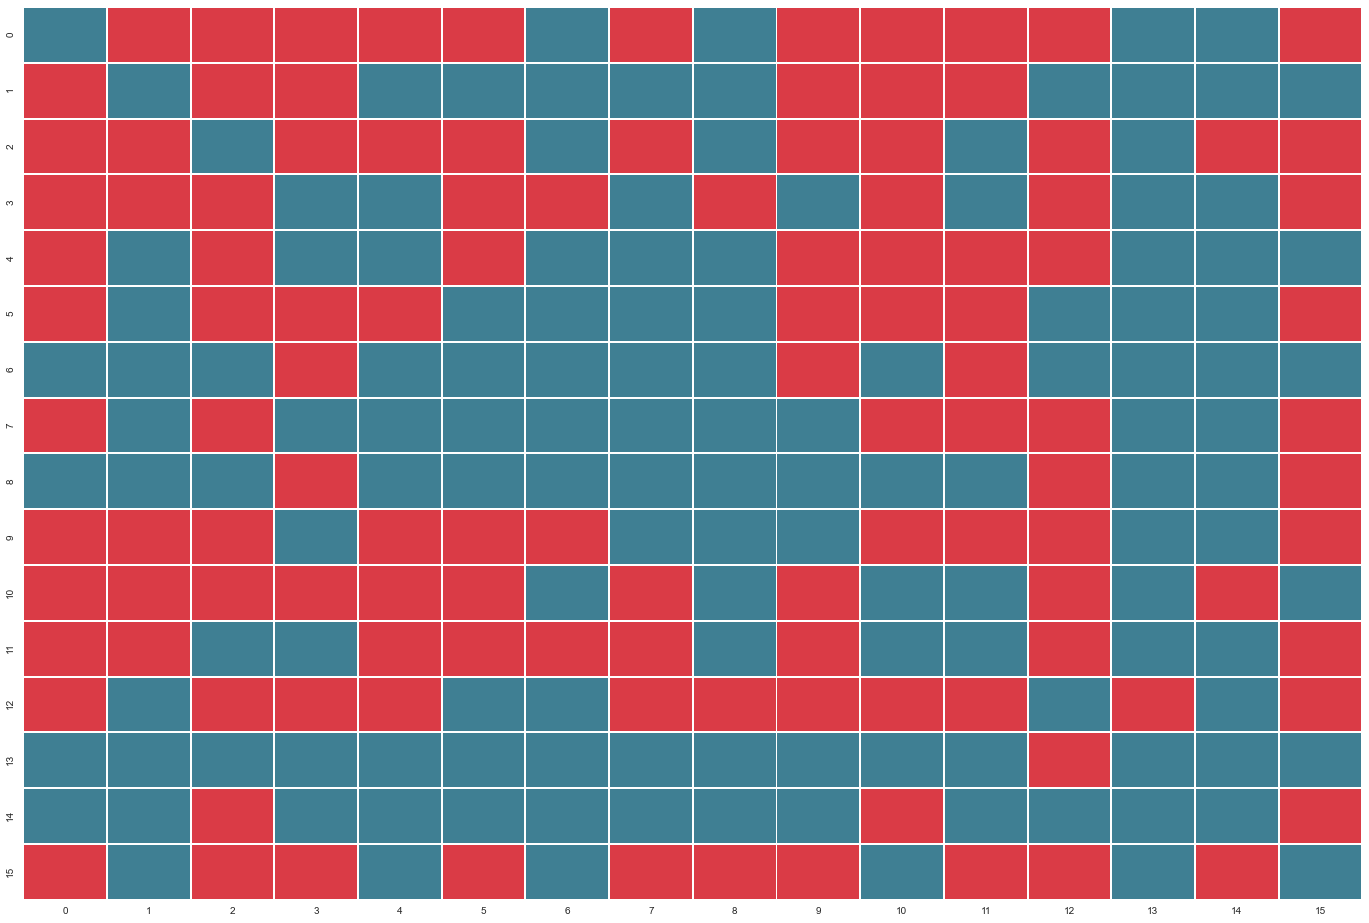

In [13]:
# t-test pvals
r = np.corrcoef(topics.T)
n = remaining_songs
t=r*np.sqrt((n-2)/(1-r*r))
import scipy.stats as ss
f, ax = plt.subplots(figsize=(24, 16))
sns.heatmap(ss.t.cdf(t, n-2) < .05, cmap=cmap, ax=ax, cbar=False)

{1: 10,
 2: 100,
 3: 1003,
 4: 1006,
 5: 1007,
 6: 1009,
 7: 101,
 8: 1011,
 9: 1012,
 10: 1013,
 11: 1014,
 12: 1016,
 13: 1018,
 14: 1019,
 15: 102,
 16: 1020,
 17: 1021,
 18: 1022,
 19: 1024,
 20: 1025,
 21: 1027,
 22: 1031,
 23: 1032,
 24: 1033,
 25: 1034,
 26: 1037,
 27: 1039,
 28: 104,
 29: 1040,
 30: 1041,
 31: 1042,
 32: 1044,
 33: 1045,
 34: 1046,
 35: 1048,
 36: 105,
 37: 1051,
 38: 1052,
 39: 1053,
 40: 1054,
 41: 1055,
 42: 1056,
 43: 1058,
 44: 1059,
 45: 106,
 46: 1061,
 47: 1062,
 48: 1063,
 49: 1064,
 50: 1066,
 51: 1067,
 52: 1068,
 53: 1069,
 54: 107,
 55: 1070,
 56: 1071,
 57: 1072,
 58: 1073,
 59: 1076,
 60: 1078,
 61: 1082,
 62: 1084,
 63: 1085,
 64: 1086,
 65: 1087,
 66: 1089,
 67: 109,
 68: 1091,
 69: 1094,
 70: 1096,
 71: 1097,
 72: 1098,
 73: 1099,
 74: 1100,
 75: 1101,
 76: 1102,
 77: 1103,
 78: 1104,
 79: 1106,
 80: 1107,
 81: 1109,
 82: 111,
 83: 1110,
 84: 1111,
 85: 1112,
 86: 1113,
 87: 1114,
 88: 1116,
 89: 1117,
 90: 1118,
 91: 1119,
 92: 112,
 93: 1120

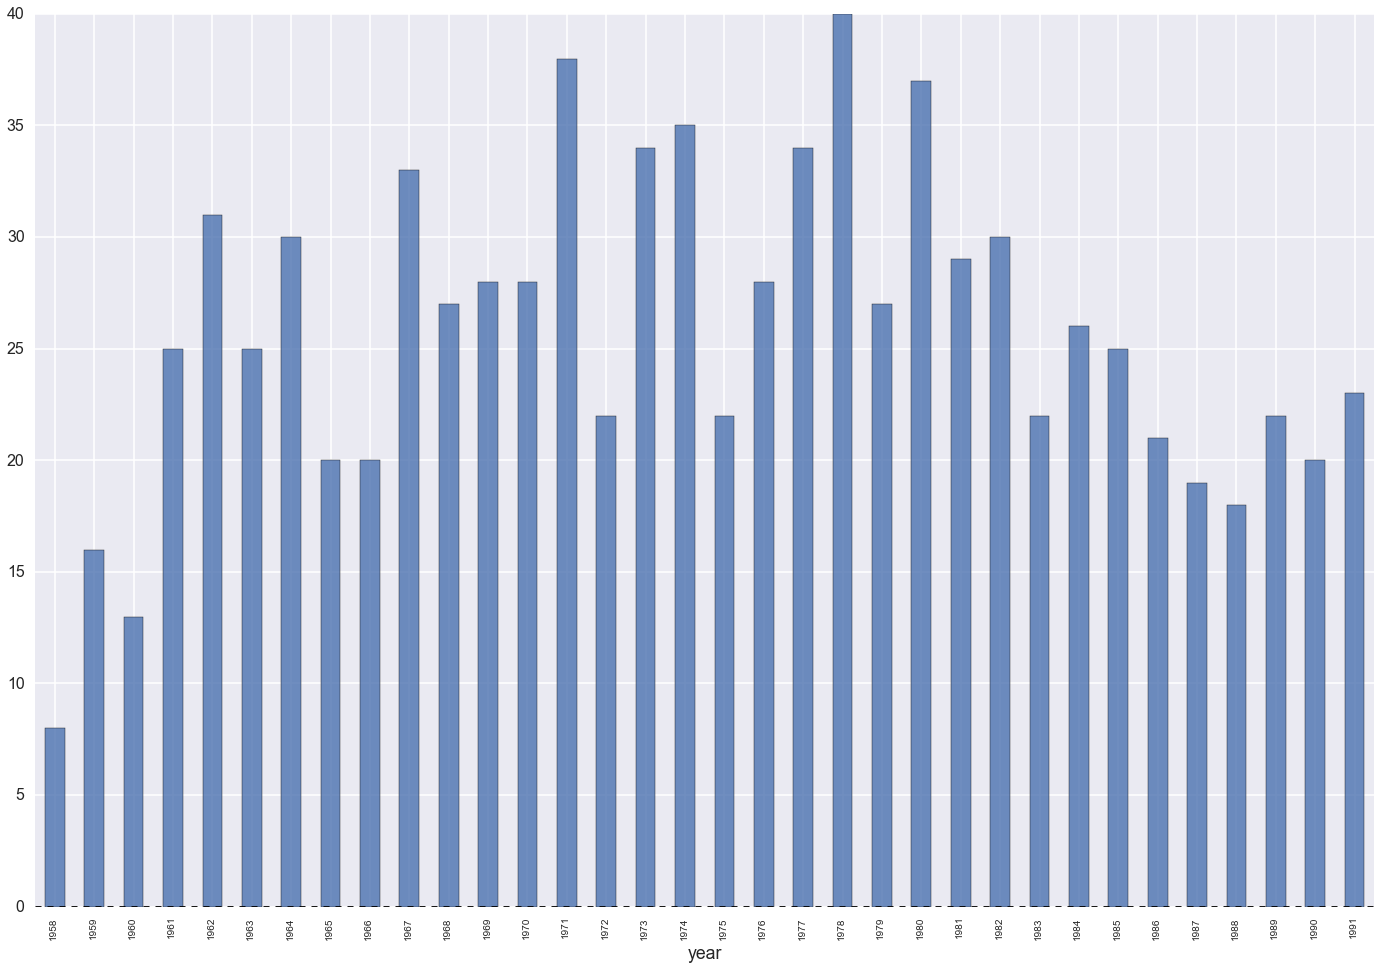

In [861]:
# Plot number of retained songs by year
songs['year'] = [date.year for date in songs['chart_date']]
songs.drop([u'chart_date', u'target_rank', 
            u'actual_rank', u'peak_rank', u'weeks_on_chart']
           ,inplace=True,axis=1)

years = songs.groupby('year')
years.size().plot(kind='bar', alpha=0.8, figsize=(24,16))


In [829]:
bins = pd.cut(xrange(1958,1992), bins=np.linspace(1957,1992,6))
bins = {bn:bins[i] for i, bn in enumerate(xrange(1958,1992))}
songs['year'] = songs['year'].apply(lambda x: bins[x])


In [825]:
np.linspace(1957,1992,6)

array([ 1957.,  1964.,  1971.,  1978.,  1985.,  1992.])

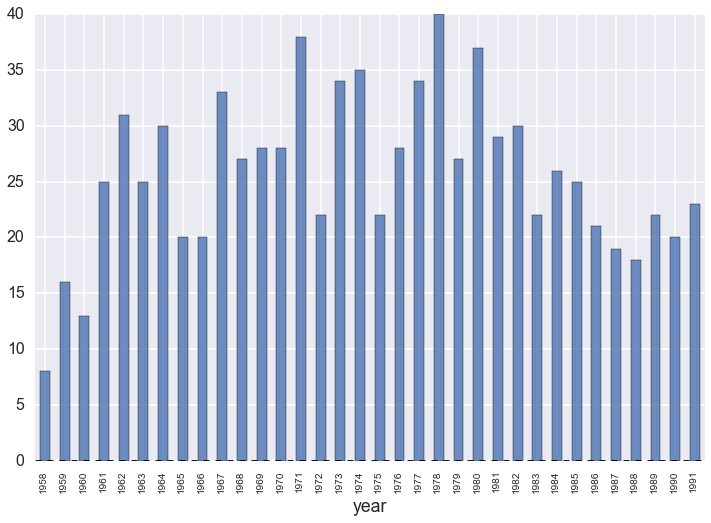

In [1056]:
years = songs.groupby('year')
years.size().plot(kind='bar', alpha=0.8, figsize=(12,8))

In [ ]:
year_topics = pd.ewma(year_topics,span=2)

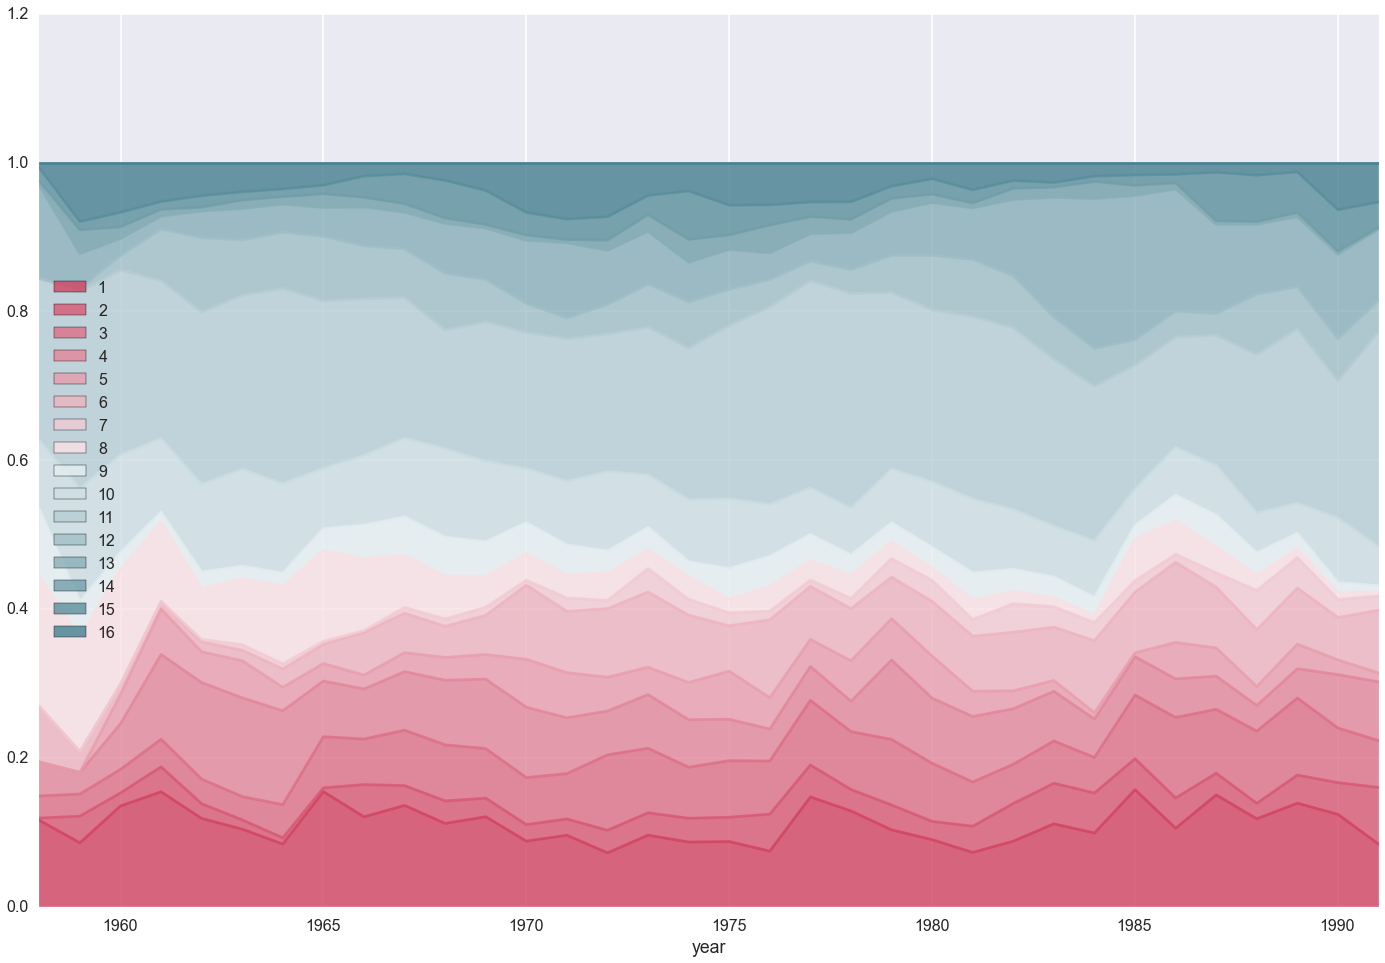

In [299]:
# TS analysis w/ 5-year exponentially weighted moving average
year_topics = topics.join(songs).groupby(by="year").mean()
pd.ewma(year_topics, span=4).plot(figsize=(24,16), alpha=0.8,kind='area', cmap=sns.diverging_palette(4,215,s=70,l=50,sep=1,n=16,as_cmap=True))

In [777]:
year_topics = topics.join(songs)

AttributeError: 'list' object has no attribute 'get_figure'

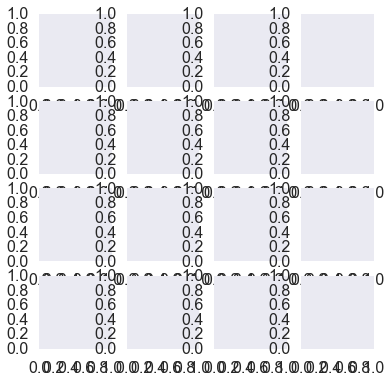

In [307]:
fig, axes = plt.subplots(4, 4, figsize=(6,6))
pd.ewma(year_topics, span=4).plot(subplots=True, ax=[x for xs in axes for x in xs], figsize=(24,16), sharex=False)

In [859]:
year_topics

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.305556,...,0.333333,0.000000,0.000000,1984-03-24,49,51,An Innocent Man,Billy Joel,10,18
1003,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,...,0.000000,0.000000,0.000000,1978-01-28,3,1,Baby Come Back,Player,1,32
1006,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1961-06-26,34,35,Three Hearts In A Tangle,Roy Drusky,35,16
1007,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.050000,1990-10-20,25,25,Unchained Melody,Righteous Brothers,13,44
1009,0.000000,0.000000,0.192308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1975-09-06,93,95,The Millionaire,Dr. Hook,95,5
101,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,...,0.000000,0.000000,0.000000,1980-03-08,85,85,A Lesson In Leavin',Dottie West,73,5
1011,0.000000,0.000000,0.483871,0.354839,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,...,0.000000,0.000000,0.064516,1989-07-29,46,44,I Drove All Night,Cyndi Lauper,6,15
1012,0.000000,0.000000,0.210526,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1991-02-23,14,13,All This Time,Sting,5,15
1013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1984-02-11,45,44,Time Will Reveal,Debarge,18,18
1014,0.200000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1976-07-24,47,47,Play That Funky Music,Wild Cherry,1,25


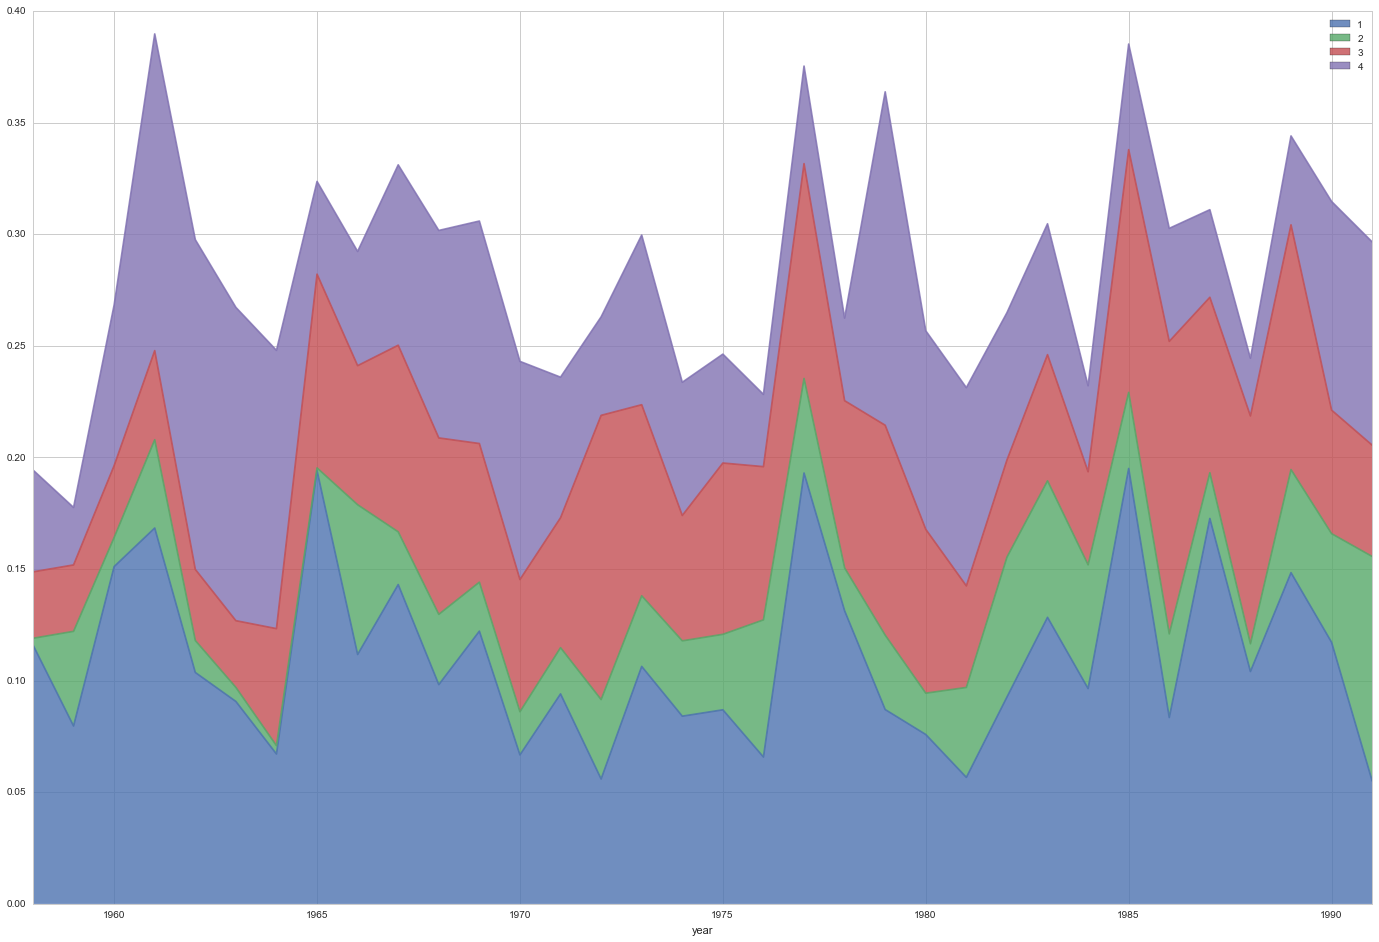

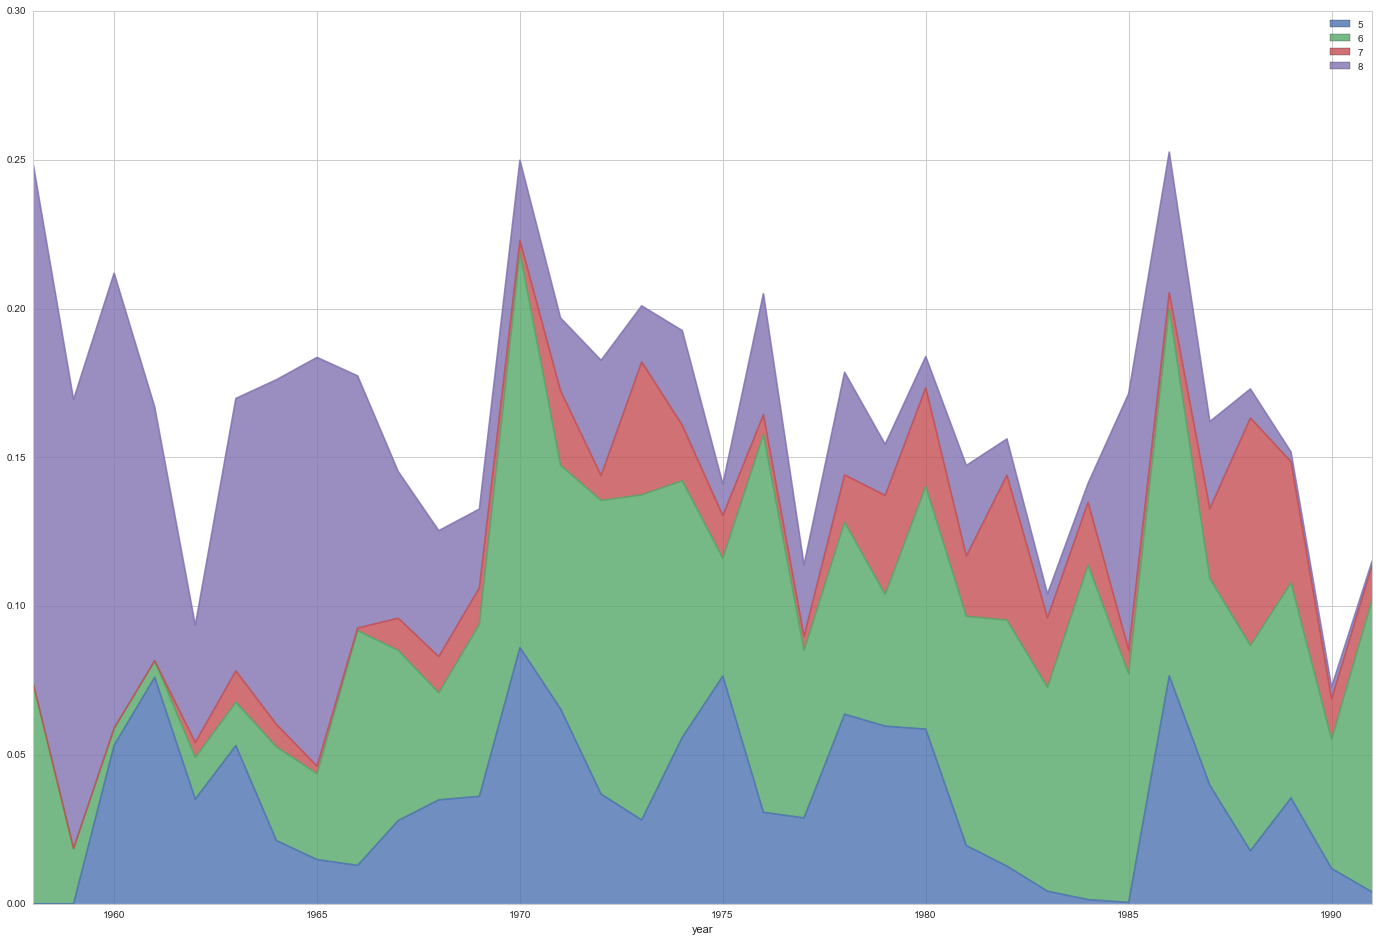

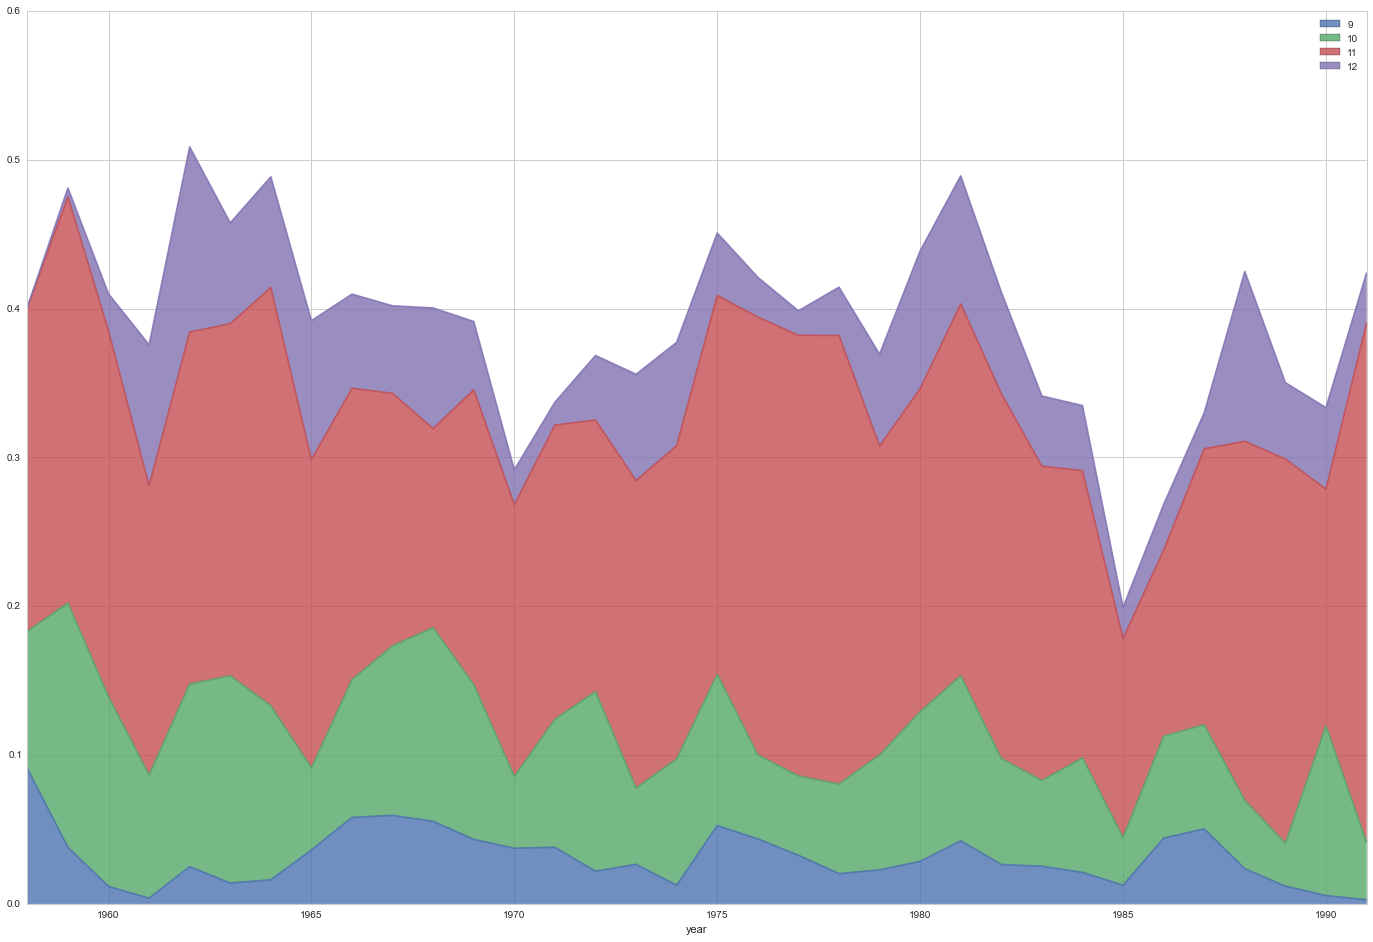

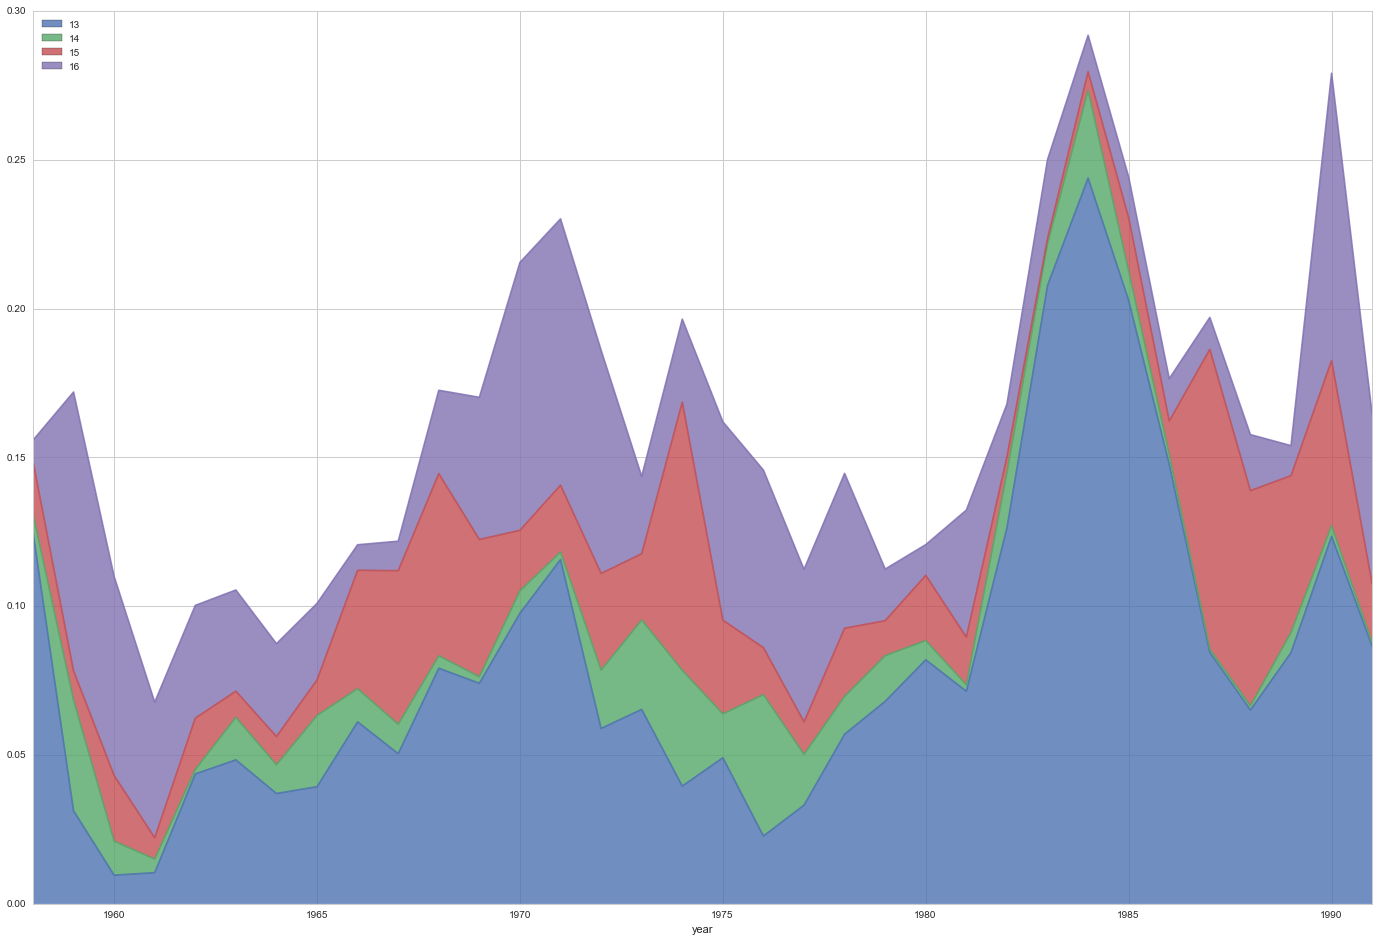

In [205]:
from scipy.interpolate import spline
year_topics.T[0:4].T.plot(figsize=(24,16), alpha=0.8,kind='area')
year_topics.T[4:8].T.plot(figsize=(24,16), alpha=0.8,kind='area')
year_topics.T[8:12].T.plot(figsize=(24,16), alpha=0.8,kind='area')
year_topics.T[12:16].T.plot(figsize=(24,16), alpha=0.8,kind='area')

In [1120]:
from sklearn.linear_model import Ridge
year_topics = topics.dropna().join(songs)
#year_topics['year'] = year_topics.index
x = np.array(year_topics.dropna().drop('year', 1).drop('artist', 1).drop('title', 1))
y = np.array(year_topics.dropna()['year'])

In [373]:
sections = pd.read_pickle("C:\RTM\model\sections.csv")

In [1093]:
vs = sections[sections['label'] == 'verse']
bs = sections[sections['label'] == 'bridge']
cs = sections[sections['label'] == 'chorus']
ps = sections[sections['label'] == 'prechorus']


In [1094]:
songparts = pd.concat([vs, bs, cs, ps])
songparts.index = range(len(songparts.index))

In [1095]:
x = np.array(songparts.drop('label', 1))
y = np.array(songparts['label'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
label,,,,,,,,,,,,,,,,
bridge,334,334,334,334,334,334,334,334,334,334,334,334,334,334,334,334
chorus,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742
prechorus,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
verse,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859


In [1085]:
svc = RandomForestClassifier(n_estimators=200, n_jobs = 2)

In [1088]:
from sklearn import cross_validation
from sklearn import svm

X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.4)

In [944]:
svc = Ridge(alpha = 1.0)


In [1072]:
X_train.shape, y_train.shape

((1369L, 16L), (1369L,))

In [1071]:
X_test.shape, y_test.shape

((587L, 16L), (587L,))

In [901]:
from sklearn.linear_model import ElasticNetCV
svc = ElasticNetCV(n_jobs=2)

In [939]:
p 

In [1000]:
kf_total = cross_validation.KFold(len(p[:,6:8]), n_folds=10, indices=True, shuffle=True, random_state=4)

C:\Users\Dakota\Anaconda\lib\site-packages\sklearn\cross_validation.py:69: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  stacklevel=1)


In [1004]:
from sklearn.linear_model import ElasticNet
#svc = Ridge(alpha=1.0)
np.mean([svc.fit(p[train_indices], y[train_indices]).score(p[test_indices],y[test_indices])
for train_indices, test_indices in kf_total])

0.020463686857437168

In [1114]:

svc=RidgeCV()
svc.fit(X_train, y_train)
mse = np.mean((svc.predict(X_test) - y_test) ** 2)
avg = np.mean(np.abs((svc.predict(X_test) - y_test)))
# ok sqrt of SSD here is competitive with VW?
#
#Out[873]:
#8.7052994154277421
# using ONLY those two topics sqrt of MSE is 8.97, 
print "MSE: {}\nAVG: {}".format(np.sqrt(mse), avg)
# for ONLY features 7/8, degree 2, 60/40 test train split
# MSE: 8.90360008826
# AVG: 7.51026425494

ValueError: could not convert string to float: verse

In [1115]:
np.mean(np.abs(np.reshape([1974.8118343195267] * 845, y.shape) - y))

7.5651776898567951

In [1089]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(svc.fit(X_train, y_train).predict(X_test), y_test)

In [1090]:
svc.predict(X_test)

array(['bridge', 'bridge', 'verse', 'verse', 'verse', 'verse', 'bridge',
       'bridge', 'verse', 'verse', 'chorus', 'bridge', 'verse', 'chorus',
       'bridge', 'verse', 'verse', 'chorus', 'chorus', 'verse', 'chorus',
       'bridge', 'bridge', 'verse', 'verse', 'verse', 'chorus', 'verse',
       'verse', 'verse', 'chorus', 'verse', 'bridge', 'chorus', 'verse',
       'verse', 'verse', 'verse', 'verse', 'chorus', 'verse', 'verse',
       'verse', 'chorus', 'bridge', 'verse', 'chorus', 'chorus', 'chorus',
       'verse', 'verse', 'verse', 'verse', 'verse', 'chorus', 'chorus',
       'chorus', 'verse', 'verse', 'chorus', 'verse', 'verse', 'verse',
       'verse', 'chorus', 'verse', 'chorus', 'verse', 'verse', 'verse',
       'verse', 'verse', 'chorus', 'verse', 'chorus', 'verse', 'chorus',
       'chorus', 'chorus', 'verse', 'verse', 'chorus', 'chorus', 'verse',
       'bridge', 'verse', 'chorus', 'verse', 'verse', 'verse', 'verse',
       'verse', 'verse', 'verse', 'verse', 'verse', 

In [1091]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
poly.fit(x[:,6:8])
p = poly.transform(x[:,6:8])

In [1073]:
y_test

array(['verse', 'bridge', 'verse', 'chorus', 'verse', 'chorus', 'chorus',
       'verse', 'verse', 'chorus', 'bridge', 'chorus', 'chorus', 'chorus',
       'verse', 'verse', 'bridge', 'bridge', 'chorus', 'chorus',
       'prechorus', 'verse', 'chorus', 'bridge', 'verse', 'verse',
       'bridge', 'bridge', 'bridge', 'chorus', 'chorus', 'verse', 'verse',
       'verse', 'verse', 'chorus', 'verse', 'bridge', 'verse', 'chorus',
       'verse', 'chorus', 'verse', 'verse', 'chorus', 'verse', 'verse',
       'verse', 'chorus', 'verse', 'chorus', 'bridge', 'verse', 'verse',
       'chorus', 'bridge', 'verse', 'chorus', 'verse', 'chorus', 'verse',
       'verse', 'bridge', 'chorus', 'bridge', 'verse', 'bridge', 'chorus',
       'chorus', 'chorus', 'chorus', 'chorus', 'verse', 'verse', 'bridge',
       'chorus', 'verse', 'chorus', 'verse', 'verse', 'verse', 'verse',
       'verse', 'chorus', 'verse', 'verse', 'bridge', 'verse', 'chorus',
       'verse', 'chorus', 'chorus', 'chorus', 'bridge', '

Confusion matrix, without normalization
[[ 44  30   0  23]
 [ 51 119   1  82]
 [  0   0   0   1]
 [ 41 146   6 239]]
Normalized confusion matrix
[[ 0.45  0.31  0.    0.24]
 [ 0.2   0.47  0.    0.32]
 [ 0.    0.    0.    1.  ]
 [ 0.09  0.34  0.01  0.55]]


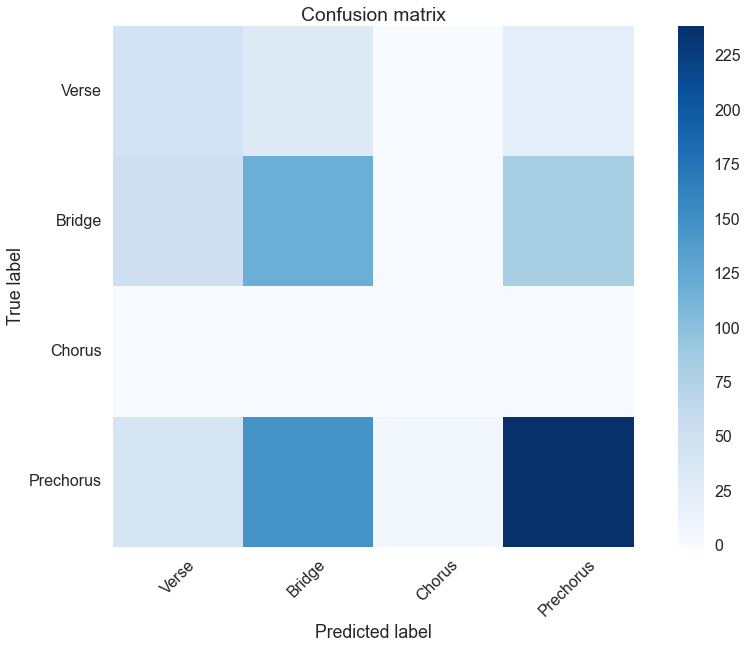

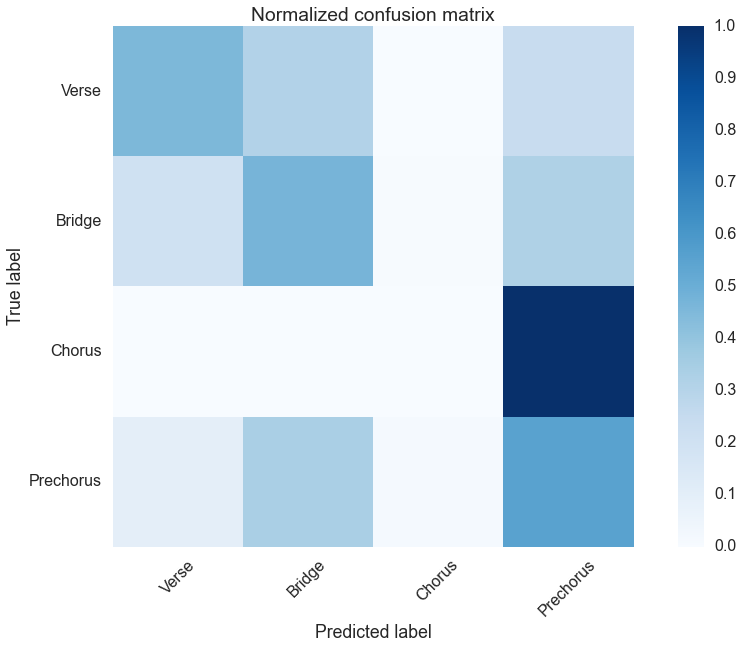

In [1113]:
sns.set_palette("BrBG")
names = ["Verse", "Bridge", "Chorus", "Prechorus"]

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [1077]:
cm

array([[ 34,  15,   0,  26],
       [ 24,  87,   1,  75],
       [  0,   0,   0,   0],
       [ 34, 112,   4, 175]])

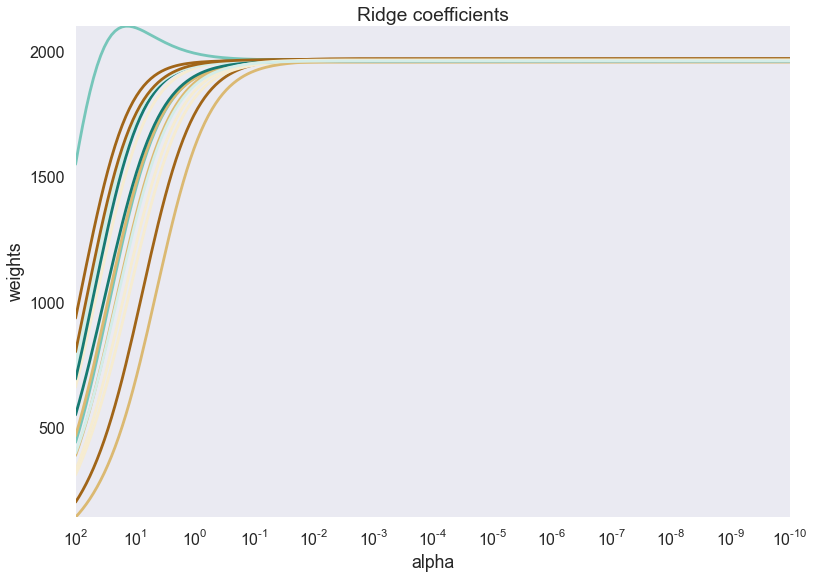

In [1125]:
n_alphas = 200
alphas = np.logspace(-10, 2, n_alphas)
svc = Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    svc.set_params(alpha=a)
    svc.fit(x, y)
    coefs.append(svc.coef_)

###############################################################################
# Display results

ax = plt.gca()
#ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients')
plt.axis('tight')
plt.show()

1
1872.53
2
1471.78
3
1725.54
4
1799.81
5
1568.91
6
1776.14
7
1070.74
8
1581.86
9
1283.52
10
1802.18
11
2090.96
12
1613.08
13
1817.10
14
828.73
15
1361.68
16
1453.24


In [1038]:
np.mean(y)

1974.8118343195267